# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#Refered/code-reusebility from ipynb from applied_ai_course notes 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
#Natural-Text-pre-processing 
#finding the which sentence contains html tags

import re

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;


4
I wish I'd read the reviews before making this purchase. It's basically a cardsotck box that is sticky all over the OUTSIDE. Those pink-ish things that look like entrances "into" the trap? They're just pictures. There *is no* inside of the trap. All the flies will be stuck to the OUTSIDE. It's basically fly paper, just horribly, horribly HORRIBLY overpriced.<br /><br />Do yourself a favor and just get fly paper or fly strips. Same yuck factor, but much cheaper.


In [15]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

stop = set(stopwords.words('english')) #set of stopwords

sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
sno.stem('delicious')
#stop


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SatyaKrishna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'delici'

In [16]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm
import os

final_string=[] #creating a empty list for storing final preprocessed data
cleanedtext_length=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[] #empty list for store after remove html and punc's and alfanumeric and words >2 and not in stop and converted to lowercase 
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)# above steps are stored here 
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews stored with above 
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews stored with above 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words stored in str1   
    final_string.append(str1) #here str1 stored in final_string
    cleanedtext_length.append(len(str1))
print("filtered sentences are stored successfully")


100%|███████████████████████████████████| 87773/87773 [02:50<00:00, 515.67it/s]


filtered sentences are stored successfully


In [17]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final['cleanedText_length']=cleanedtext_length#addingcolumn  a length of cleaned text
print("cleaned data is added successfully in cleaned text feature")
final.shape
final.head(3)
#final.CleanedText.values[:50]

cleaned data is added successfully in cleaned text feature


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,cleanedText_length
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...,149
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...,64
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infest fruitfli liter everywher fli around kit...,357


In [18]:
#all the filtered sentences and positive and negative reviews with bytes foramt for faster processing 
# are stored in final_string
#Now most common positive words and negitive words

freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words in review : ",freq_dist_positive.most_common(20))
print('-' *100)
print("Most Common Negative Words in review: ",freq_dist_negative.most_common(20))

Most Common Positive Words in review :  [(b'like', 35242), (b'tast', 30840), (b'good', 27671), (b'flavor', 26981), (b'love', 26733), (b'great', 25050), (b'one', 23767), (b'use', 22755), (b'tri', 21157), (b'product', 20972), (b'coffe', 20647), (b'tea', 19247), (b'food', 18115), (b'get', 17728), (b'make', 17278), (b'dog', 14274), (b'would', 13929), (b'eat', 13453), (b'time', 12997), (b'realli', 12951)]
----------------------------------------------------------------------------------------------------
Most Common Negative Words in review:  [(b'tast', 8828), (b'like', 8406), (b'product', 6907), (b'one', 5184), (b'flavor', 4936), (b'would', 4561), (b'tri', 4539), (b'coffe', 3871), (b'good', 3846), (b'use', 3690), (b'food', 3625), (b'get', 3456), (b'buy', 3385), (b'dog', 3214), (b'dont', 3017), (b'order', 3009), (b'tea', 2865), (b'even', 2835), (b'eat', 2693), (b'box', 2677)]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [19]:
## Similartly you can do preprocessing for review summary also.
## Similartly you can do preprocessing for review summary also.
#finding html tags in summary text 

j=0;
for summary in final['Summary'].values:
    if (len(re.findall('<.*?>', summary))):
        print(j)
        print(summary)
    else:
        print("There is no html tags")
        print('-'*50)
        break;
    j += 1;
final["Summary"].head(10)

There is no html tags
--------------------------------------------------


22620                              made in china
22621                          Dog Lover Delites
70677                    only one fruitfly stuck
70676    Doesn't work!! Don't waste your money!!
70675                              A big rip off
70673     THIS ITEM IS EXCELLENT TO KILL INSECTS
70672                                Didn't work
70671                        Gross but effective
70670                        Didn't work for me.
70669                             Waste of money
Name: Summary, dtype: object

In [20]:
#removing if any html tags and punctuations in summary feature
#observed there is no html tags in summary attribute 

#def cleanhtml(s_sentence): #function to clean the word of any html-tags
#    s_cleanr = re.compile('<.*?>')
#    s_cleantext = re.sub(s_cleanr, ' ', s_sentence)
#    return s_cleantext

def cleanpunc(s_sentence): #function to clean the word of any punctuation or special characters
    s_cleaned = re.sub(r'[?|!|\'|"|#]',r'',s_sentence)
    s_cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',s_cleaned)
    return  s_cleaned

s_stop = set(stopwords.words('english')) #set of stopwords

s_sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
s_sno.stem('wow')

'wow'

In [21]:
summary_final_string=[] #creating a empty list for storing final preprocessed data
summary_length=[]
summary_all_positive_words=[] # store words from +ve summary here
summary_all_negative_words=[] # store words from -ve summary here.
for j, summary_sent in enumerate(tqdm(final['Summary'].values)):
    summary_filtered_sentence=[] #empty list for store after remove  punc's and alphanumeric and words >2 and not in stop and converted to lowercase 
    #summary_sent=cleanhtml(summary_sent) # remove HTMl tags
    for s_w in summary_sent.split():
        for s_cleaned_words in cleanpunc(s_w).split():
            if((s_cleaned_words.isalpha()) & (len(s_cleaned_words)>2)):    
                if(s_cleaned_words.lower() not in s_stop):
                    s_s=(s_sno.stem(s_cleaned_words.lower())).encode('utf8')
                    summary_filtered_sentence.append(s_s)# above steps are stored here 
                    if (final['Score'].values)[j] == 1: 
                        summary_all_positive_words.append(s_s) #list of all words used to describe positive summary stored with above 
                    if(final['Score'].values)[j] == 0:
                        summary_all_negative_words.append(s_s) #list of all words used to describe negative summary reviews stored with above 
    s_str1 = b''.join(summary_filtered_sentence) #final string of cleaned words stored in s_str1   
    summary_final_string.append(s_str1) #here s_str1 stored in summary_final_string
    summary_length.append(len(s_str1))
print("filtered summary are stored successfully in summary_final_string")
len(summary_final_string)

100%|██████████████████████████████████| 87773/87773 [00:11<00:00, 7820.28it/s]


filtered summary are stored successfully in summary_final_string


87773

In [22]:
s_freq_dist_positive=nltk.FreqDist(summary_all_positive_words)
s_freq_dist_negative=nltk.FreqDist(summary_all_negative_words)
print("Most Common Positive Words in summary : ",s_freq_dist_positive.most_common(10))
print('-' *100)
print("Most Common Negative Words in summary : ",s_freq_dist_negative.most_common(10))

Most Common Positive Words in summary :  [(b'great', 11454), (b'good', 7357), (b'love', 5977), (b'best', 5254), (b'tast', 3462), (b'coffe', 3401), (b'tea', 3154), (b'delici', 3094), (b'dog', 3090), (b'product', 2722)]
----------------------------------------------------------------------------------------------------
Most Common Negative Words in summary :  [(b'tast', 1075), (b'like', 667), (b'good', 659), (b'disappoint', 453), (b'flavor', 431), (b'product', 429), (b'bad', 420), (b'dog', 413), (b'coffe', 399), (b'dont', 355)]


In [23]:
final['Cleanedsummary']=summary_final_string
final['Cleanedsummary_len']=summary_length
final[0:1]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,cleanedText_length,Cleanedsummary,Cleanedsummary_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...,149,b'madechina',9


In [24]:
print(final['Score'].value_counts())
print(final['Score'].shape)

1    73592
0    14181
Name: Score, dtype: int64
(87773,)


<h3>Feature_Engineering</h3>

In [25]:
#here combining both cleaned summary text and cleaned review text and cleaned text length for getting better results 
final['cleaned_&_summary'] = final['CleanedText'] + final['Cleanedsummary'].map(str)
fea_x=final['cleaned_&_summary'] + final['cleanedText_length'].map(str)
final.iloc[:,10:15].head(3)

,CleanedText,cleanedText_length,Cleanedsummary,Cleanedsummary_len,cleaned_&_summary
22620,dog love chicken product china wont buy anymor...,149,b'madechina',9,dog love chicken product china wont buy anymor...
22621,dog love saw pet store tag attach regard made ...,64,b'dogloverdelit',13,dog love saw pet store tag attach regard made ...
70677,infest fruitfli liter everywher fli around kit...,357,b'onefruitflistuck',16,infest fruitfli liter everywher fli around kit...


Apply feature engineering for cleaned text , summary text and length of cleaned text,  merging this cleaned  text ,cleaned summary and length of cleaned text into cleaned_&_summary feature,which contains cleaned text and its length and cleaned summary 

In [26]:
x=fea_x
y=final['Score']

#splitting the cleaned text and score to train, cv,test
from sklearn import model_selection
from sklearn.model_selection import train_test_split

#here we splitting the whole data to train test and cv

#splitted the data in to train and test
x_train,x_test_data,y_train,y_test_data = train_test_split(x, y, test_size=0.3, random_state=0)
#splitted the above train data into 2nd train and cross validation 
x_train_data,x_cv_data,y_train_data,y_cv_data = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

print("Data splitted sucessfully in to train ,test,cv")

Data splitted sucessfully in to train ,test,cv


# [4] Featurization

## [4.1] BAG OF WORDS

In [27]:
#APPLYING_BOW ON TRAIN DATA 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

count_vect = CountVectorizer() #in scikit-learn
final_counts_bow_train = count_vect.fit_transform(x_train_data)
final_bow_train_data=final_counts_bow_train
#transform  on testdata
final_bow_test_data = count_vect.transform(x_test_data)
#transform on cv data 
final_bow_cv_data = count_vect.transform(x_cv_data)

print("the type of count vectorizer ",type(final_bow_train_data))
print("the shape of out text BOW vectorizer ",final_bow_train_data.get_shape())
print("the number of unique words ", final_bow_train_data.get_shape()[1])
#dense_bow=final_bow_train_data.todense()
print('-' * 50 )
print('-' * 50 )
#print("the type of count vectorizer ",type(dense_bow))

print(final_bow_train_data.shape,y_train_data.shape)
print(final_bow_test_data.shape,y_test_data.shape)
print(final_bow_cv_data.shape,y_cv_data.shape)
print("Bow splitted data\n", "final_bow_train_data,y_train_data\n","final_bow_test_data,y_test_data\n","final_bow_cv_data,y_cv_data\n")


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (43008, 57624)
the number of unique words  57624
--------------------------------------------------
--------------------------------------------------
(43008, 57624) (43008,)
(26332, 57624) (26332,)
(18433, 57624) (18433,)
Bow splitted data
 final_bow_train_data,y_train_data
 final_bow_test_data,y_test_data
 final_bow_cv_data,y_cv_data



## [4.3] TF-IDF

In [28]:
#TFIDF VECTORIZER
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tfidf_train_data = tf_idf_vect.fit_transform(x_train_data)
final_tfidf_test_data = tf_idf_vect.transform(x_test_data)
final_tfidf_cv_data = tf_idf_vect.transform(x_cv_data)
print("the type of count vectorizer ",type(final_tfidf_train_data))
print("the shape of out text TFIDF vectorizer ",final_tfidf_train_data.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tfidf_train_data.get_shape()[1])
#tfidf_dense=final_tfidf_train_data.todense()
#print('-' * 50 )
#print("here below  we converting scipy to dense ")
#print('-' * 50 )
#print("the type of count vectorizer ",type(tfidf_dense))
print(final_tfidf_train_data.shape,y_train_data.shape)
print(final_tfidf_test_data.shape,y_test_data.shape)
print(final_tfidf_cv_data.shape,y_cv_data.shape)
print("Bow splitted data\n", "final_tfidf_train_data,y_train_data\n","final_tfidf_test_data,y_test_data\n","final_tfidf_cv_data,y_cv_data\n")

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (43008, 822825)
the number of unique words including both unigrams and bigrams  822825
(43008, 822825) (43008,)
(26332, 822825) (26332,)
(18433, 822825) (18433,)
Bow splitted data
 final_tfidf_train_data,y_train_data
 final_tfidf_test_data,y_test_data
 final_tfidf_cv_data,y_cv_data



# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [29]:
# Please write all the code with proper documentation
#finding the best hyper parameter  using simple loop method 
# Reference ,code re-using from sample solution ipynb
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import numpy as np
train_auc = []
cv_auc = []
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in alpha:
    nb_bow = MultinomialNB(alpha=i)
    nb_bow.fit(final_bow_train_data, y_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  nb_bow.predict_proba(final_bow_train_data)[:,1]
    y_cv_pred =  nb_bow.predict_proba(final_bow_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("alpha=",i,"cv:",cv_auc_score,"train:",train_auc_score)

alpha= 1e-05 cv: 0.8430379413648734 train: 0.9986110167686935
alpha= 0.0001 cv: 0.8611073029363572 train: 0.9982608475526227
alpha= 0.001 cv: 0.8817703854212011 train: 0.9974203000520665
alpha= 0.01 cv: 0.9028044386875753 train: 0.9951725081385474
alpha= 0.1 cv: 0.9197313367732984 train: 0.9882768900638952
alpha= 1 cv: 0.9039988489211179 train: 0.9580278547787425
alpha= 10 cv: 0.6701492000842295 train: 0.6856253281799731
alpha= 100 cv: 0.5546246098187648 train: 0.54882096111948
alpha= 1000 cv: 0.5357074335276277 train: 0.5295261172020331
alpha= 10000 cv: 0.5298396961187142 train: 0.5229602054730468
alpha= 100000 cv: 0.5277199436581835 train: 0.5202934489748463


We got optimal alpha as 0.1 

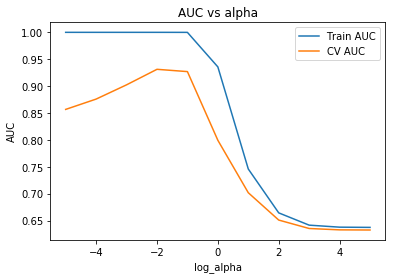

In [66]:
#plotting the results 

import math

#https://stackoverflow.com/questions/11656767/how-to-take-the-log-of-all-elements-of-a-list
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
log_alpha = [math.log10(num) for num in alpha]

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log_alpha")
plt.ylabel("AUC")
plt.title("AUC vs alpha")
plt.show()

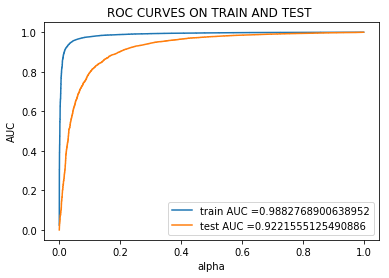

In [31]:
#performing the nb with optimal alpha for bow vectorizer 
from sklearn.metrics import roc_curve, auc

nb_bow = MultinomialNB(alpha=0.1)
nb_bow.fit(final_bow_train_data, y_train_data)


bow_train_fpr, bow_train_tpr, bow_thresholds = roc_curve(y_train_data, nb_bow.predict_proba(final_bow_train_data)[:,1])
bow_test_fpr, bow_test_tpr, bow_thresholds = roc_curve(y_test_data, nb_bow.predict_proba(final_bow_test_data)[:,1])

plt.plot(bow_train_fpr, bow_train_tpr, label="train AUC ="+str(auc(bow_train_fpr, bow_train_tpr)))
plt.plot(bow_test_fpr, bow_test_tpr, label="test AUC ="+str(auc(bow_test_fpr, bow_test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

we get test auc is 0.92

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [32]:
# Please write all the code with proper documentation
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
#first we get a features names here by using count vectorizer  
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
bow_feature_names=count_vect.get_feature_names()

#here we get a features in horizantal list
feature_log_prob=nb_bow.feature_log_prob_
print("Max bow feature_log_probability's",feature_log_prob.max(),"\n")

#we get 2 features bow_feature_names and log_probabilities_of_bow_data_ both are in list type 
#now_convert list_to_columns_for _picking _top_10_features

#https://stackoverflow.com/questions/51209933/convert-list-to-column-in-python-dataframe
#for converting to column's we require a dataframe to store these list's 
df = pd.DataFrame(feature_log_prob,columns = bow_feature_names)

#now we have a dataframe with list in horizantal column's
print("horizantal column's",df.shape,"\n")

#here we use transpose function for getting vertcal column's  better view results
df_features=df.T 
print("vertical column's",df_features.shape,"\n")

#top 10 positive features  from bow vectorizer 
print("Top 10 positive features from bow vectorizer:-\n",df_features[1].sort_values(ascending = False)[:10])

Max bow feature_log_probability's -4.2964636299691765 

horizantal column's (2, 57624) 

vertical column's (57624, 2) 

Top 10 positive features from bow vectorizer:-
 like     -4.445276
tast     -4.577882
good     -4.688557
love     -4.717112
flavor   -4.726892
great    -4.784941
one      -4.856019
use      -4.886294
tri      -4.985867
coffe    -4.997863
Name: 1, dtype: float64


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [33]:
# Please write all the code with proper documentation
#top 10 negative features from bow vectorizer  
print("\n\n Top 10 negative features from bow vecorizer:-\n",df_features[0].sort_values(ascending = False)[:10])



 Top 10 negative features from bow vecorizer:-
 tast      -4.296464
like      -4.346514
product   -4.556602
one       -4.833133
flavor    -4.905747
would     -4.947011
tri       -4.948786
good      -5.076048
coffe     -5.079586
use       -5.206837
Name: 0, dtype: float64


we got some similar features in both positive and negative features because of some  stop words we get some common features 

Bow train confusion matrix
[[ 6473   970]
 [  567 34998]]


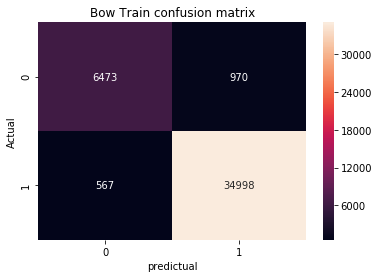

In [34]:
#Bow Train data confusion matrix
from sklearn.metrics import confusion_matrix
print("Bow train confusion matrix")
tfidf_cm_test = confusion_matrix(nb_bow.predict(final_bow_train_data),y_train_data)
sns.heatmap(tfidf_cm_test, annot=True, fmt="d")
plt.title("Bow Train confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidf_cm_test)

<h4> In Bow Train Confusion matrix</h4><br>
34998 + 6473 = 41461 are correctly classified<br> 
567 + 970 = 1537  are in-correctly classified <br>
which is model  good trained in train data 

Bow Test confusion matrix
[[ 2867  1085]
 [ 1361 21019]]


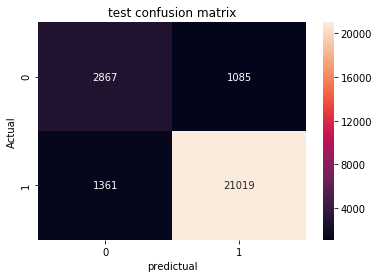

In [35]:
#Test data confusion matrix 
from sklearn.metrics import confusion_matrix
print("Bow Test confusion matrix")
cm_test = confusion_matrix(nb_bow.predict(final_bow_test_data),y_test_data)
sns.heatmap(cm_test, annot=True, fmt="d")
plt.title("test confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(cm_test)

<h4> In Bow  Test Confusion matrix</h4><br>
21019 + 2867 = 23886 are correctly classified<br> 
1361 + 1085 = 2446  are in-correctly classified <br>
which is in testdata performed a good  confusionmatrix 

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [36]:
# Please write all the code with proper documentation
#finding the best alpha with use of auc scores 
train_auc = []
cv_auc = []
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in alpha:
    tfidf_nb = MultinomialNB(alpha=i)
    tfidf_nb.fit(final_tfidf_train_data, y_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  tfidf_nb.predict_proba(final_tfidf_train_data)[:,1]
    y_cv_pred =  tfidf_nb.predict_proba(final_tfidf_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("alpha=",i,"cv:",cv_auc_score,"train:",train_auc_score)

alpha= 1e-05 cv: 0.8567112499601856 train: 1.0
alpha= 0.0001 cv: 0.875885704768174 train: 1.0
alpha= 0.001 cv: 0.9023753278053233 train: 1.0
alpha= 0.01 cv: 0.9312543574661756 train: 0.9999999881523476
alpha= 0.1 cv: 0.926992268926002 train: 0.999944430560751
alpha= 1 cv: 0.7992947319339895 train: 0.9357325909015083
alpha= 10 cv: 0.7017788194407579 train: 0.7458895675575259
alpha= 100 cv: 0.6509560103835985 train: 0.6643244950372553
alpha= 1000 cv: 0.6352749052416999 train: 0.6414922639568506
alpha= 10000 cv: 0.6327458053305304 train: 0.637752019313885
alpha= 100000 cv: 0.6324588982555979 train: 0.6373390101491729


we got optimal alpha is 0.01

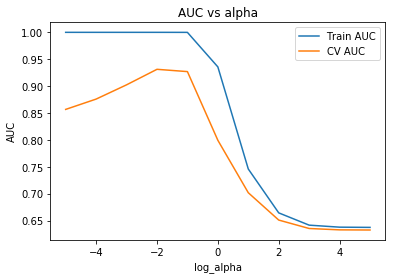

In [57]:
#plotting the results
plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log_alpha")
plt.ylabel("AUC")
plt.title("AUC vs alpha")
plt.show()

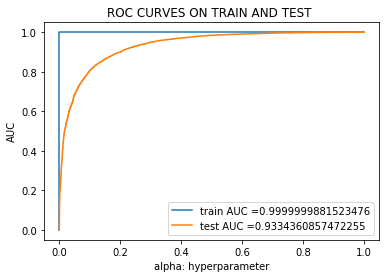

In [38]:
#performing the nb with optimal  alpha for tfidf vectorizer
tfidf_nb = MultinomialNB(alpha=0.01)
tfidf_nb.fit(final_tfidf_train_data, y_train_data)


tfidf_train_fpr, tfidf_train_tpr, tfidf_thresholds = roc_curve(y_train_data, tfidf_nb.predict_proba(final_tfidf_train_data)[:,1])
tfidf_test_fpr, tfidf_test_tpr, tfidf_thresholds = roc_curve(y_test_data, tfidf_nb.predict_proba(final_tfidf_test_data)[:,1])

plt.plot(tfidf_train_fpr, tfidf_train_tpr, label="train AUC ="+str(auc(tfidf_train_fpr, tfidf_train_tpr)))
plt.plot(tfidf_test_fpr, tfidf_test_tpr, label="test AUC ="+str(auc(tfidf_test_fpr, tfidf_test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [73]:
# Please write all the code with proper documentation
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
#first we get a features names here by using count vectorizer  
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
tfidf_feature_names=tf_idf_vect.get_feature_names()

#here we get a features in horizantal list
tfidf_feature_log_prob=tfidf_nb.feature_log_prob_
print("Max tfidf feature_log_probability's",tfidf_feature_log_prob.max(),"\n")

#we get 2 features bow_feature_names and log_probabilities_of_bow_data_ both are in list type 
#now_convert list_to_columns_for _picking _top_10_features

#https://stackoverflow.com/questions/51209933/convert-list-to-column-in-python-dataframe
#for converting to column's we require a dataframe to store these list's 
df = pd.DataFrame(tfidf_feature_log_prob,columns = tfidf_feature_names)

#now we have a dataframe with list in horizantal column's
print("horizantal column's",df.shape,"\n")

#here we use transpose function for getting vertcal column's  better view results
tfidf_features=df.T 
print("vertical column's",tfidf_features.shape,"\n")

# top 10 positive features 
print("Top 10 positive features from tfidf vectorizer:-\n",tfidf_features[1].sort_values(ascending = False)[:10])


Max tfidf feature_log_probability's -6.19081254606915 

horizantal column's (2, 822825) 

vertical column's (822825, 2) 

Top 10 positive features from tfidf vectorizer:-
 love     -6.328254
great    -6.347200
like     -6.353357
tast     -6.397574
good     -6.401636
coffe    -6.426368
flavor   -6.463741
tea      -6.494209
use      -6.622779
one      -6.649453
Name: 1, dtype: float64


Above feat_log_prob is applied in tfidf_nb model for picking which feature has more log_probability and printing  top 10 features 


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [40]:
# Please write all the code with proper documentation
#top 10 negative features 
print("Top 10 positive features from tfidf vectorizer:-\n",tfidf_features[0].sort_values(ascending = False)[:10])

Top 10 positive features from tfidf vectorizer:-
 tast      -6.190813
like      -6.318068
product   -6.374451
coffe     -6.649898
would     -6.676112
flavor    -6.711452
one       -6.739696
tri       -6.771742
buy       -6.934771
order     -6.939832
Name: 0, dtype: float64


TFIDF Train confusion matrix
[[ 7039     2]
 [    1 35966]]


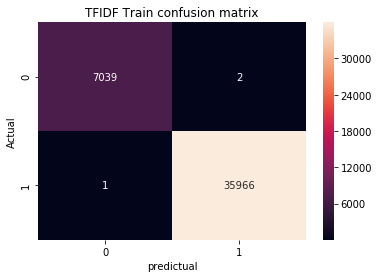

In [41]:
#TFIDf Train data confusion matrix
print("TFIDF Train confusion matrix")
tfidf_cm_test = confusion_matrix(tfidf_nb.predict(final_tfidf_train_data),y_train_data)
sns.heatmap(tfidf_cm_test, annot=True, fmt="d")
plt.title("TFIDF Train confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidf_cm_test)

<h4> In TFIDF Train Confusion matrix</h4><br>
35966 + 7039 = 43005 are correctly classified<br> 
1 + 2 = 3  are in-correctly classified <br>
which is our model is well  trained in train data

TFIDF Test confusion matrix
[[ 1524   160]
 [ 2704 21944]]


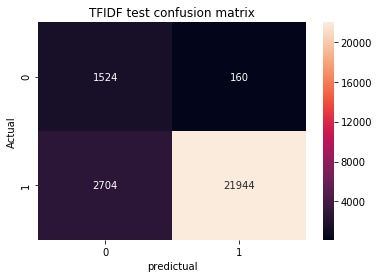

In [42]:
#TFIDf Test data confusion matrix
print("TFIDF Test confusion matrix")
tfidf_cm_test = confusion_matrix(tfidf_nb.predict(final_tfidf_test_data),y_test_data)
sns.heatmap(tfidf_cm_test, annot=True, fmt="d")
plt.title("TFIDF test confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidf_cm_test)

<h4> In TFIDF Test Confusion matrix</h4><br>
21944 + 1524 = 23468 are correctly classified<br> 
2704 + 160 = 2864  are in-correctly classified <br>
which is in testdata performed good  confusionmatrix 

# [6] Conclusions

In [60]:
#Please compare all your models using Prettytable library
#compare all your models using Prettytable library
#ref : http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Best Alpha", "Train_Auc","cv_auc","test_auc"]

x.add_row(["BOW", "Multinominal",0.1,0.98,0.91,0.92])
x.add_row(["TF-IDf","Multinominal",0.01,0.99,0.93,0.93 ])
print(x)

+------------+--------------+------------+-----------+--------+----------+
| Vectorizer |    Model     | Best Alpha | Train_Auc | cv_auc | test_auc |
+------------+--------------+------------+-----------+--------+----------+
|    BOW     | Multinominal |    0.1     |    0.98   |  0.91  |   0.92   |
|   TF-IDf   | Multinominal |    0.01    |    0.99   |  0.93  |   0.93   |
+------------+--------------+------------+-----------+--------+----------+


<h3>Conclusions</h3><br>
1.For  Naive bayes classifier TF-IDF is the best vectorizer which gives maximum test auc 0.93 and BOW Vectorizer also perform's closer to TFIDF ,Bow vectorizer got's 0.92 test auc score <br>
2.And dataset is imbalance so most of positive point's are predicted than negative points <br>
3.After applying feature engineering get 1% more in TF-IDF Test Auc score and Bow Test Auc  by mergeing cleaned_summary and length of cleaned_text ,<br>
4.Both BOW and TF-IDF are gives nearly equal performance <br>
5.We got train, cv, test auc scores are good it not be under and over fit it's a good model <br>
6.Confusion matrix also good results in both Bow and Tfidf data, and Tf-idf train confusion matrix trained perfectly compare to Bow <br>
7.Representation on x-axis train _auc,cv-auc plot is log10(alpha) which shows alpha range power form  <br>
8.For getting top 10 features we use fea_log_prob on multinominal classifier model on train data  that which gives log_probabililties , we pick features which gives high log_prob and considered as important features 